In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import copy

In [ ]:
ROOT_DATA_DIR = '/content/drive/MyDrive/ImageOutpainting/datasets'

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 200
PATIENCE = 20
LAMBDA_L1 = 80
LEARNING_RATE = 0.0002
VAL_PERCENT = 0.1

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
class CarPlateDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.original_files = sorted(glob.glob(os.path.join(root_dir, 'images', '*.*')))
        self.mask_files = sorted(glob.glob(os.path.join(root_dir, 'masks', '*.*')))

        if len(self.original_files) == 0:
            raise RuntimeError(f"Cannot find {os.path.join(root_dir, 'images')}")
        if len(self.original_files) != len(self.mask_files):
            print(f"Total images: ({len(self.original_files)}) and masks:({len(self.mask_files)}) not equal!")

    def __len__(self):
        return len(self.original_files)

    def __getitem__(self, idx):
        orig_path = self.original_files[idx]
        mask_path = self.mask_files[idx]

        orig_img = Image.open(orig_path).convert("RGB")
        mask_img = Image.open(mask_path).convert("L")

        orig_img = orig_img.resize((IMG_SIZE, IMG_SIZE), Image.BICUBIC)
        mask_img = mask_img.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)

        mask_np = np.array(mask_img)
        mask_np = (mask_np > 128).astype(np.float32)
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0)

        if self.transform:
            orig_tensor = self.transform(orig_img)

        orig_01 = (orig_tensor + 1) / 2
        input_tensor = orig_01 * mask_tensor
        input_tensor = (input_tensor * 2) - 1

        return input_tensor, orig_tensor

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# MODEL ARCHITECTURE

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize: layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout: layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)
    def forward(self, x): return self.model(x)

In [ ]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True)
        ]
        if dropout: layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)
    def forward(self, x, skip):
        x = self.model(x)
        x = torch.cat((x, skip), 1)
        return x

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )
    def forward(self, x):
        d1 = self.down1(x); d2 = self.down2(d1); d3 = self.down3(d2); d4 = self.down4(d3)
        d5 = self.down5(d4); d6 = self.down6(d5); d7 = self.down7(d6); d8 = self.down8(d7)
        u1 = self.up1(d8, d7); u2 = self.up2(u1, d6); u3 = self.up3(u2, d5); u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3); u6 = self.up6(u5, d2); u7 = self.up7(u6, d1)
        return self.final(u7)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        def d_block(in_f, out_f, norm=True):
            layers = [nn.Conv2d(in_f, out_f, 4, 2, 1)]
            if norm: layers.append(nn.InstanceNorm2d(out_f))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *d_block(in_channels*2, 64, norm=False),
            *d_block(64, 128),
            *d_block(128, 256),
            *d_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )
    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# UTILS

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='best_generator.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f}, {val_loss:.6f}). Saving model')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def lambda_rule(epoch):
    decay_start = 100
    if epoch < decay_start: return 1.0
    else: return 1.0 - max(0, epoch + 1 - decay_start) / float(EPOCHS - decay_start + 1)

# MAIN EXECUTION

Data Loaded: 1000 total. Train: 912, Val: 112
[Epoch 0/200] [G Loss: 38.2073] [Val L1: 0.4499] [LR: 0.000200]
Validation loss decreased (inf, 0.449913). Saving model


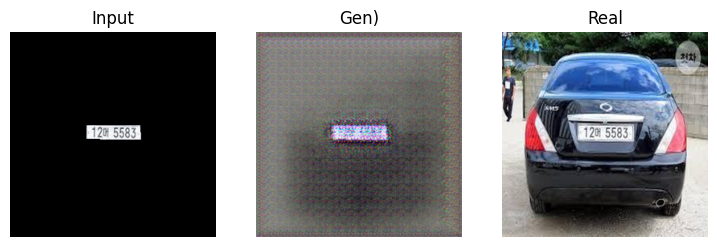

[Epoch 1/200] [G Loss: 36.9817] [Val L1: 0.4424] [LR: 0.000200]
Validation loss decreased (0.449913, 0.442424). Saving model
[Epoch 2/200] [G Loss: 36.6990] [Val L1: 0.4726] [LR: 0.000200]
EarlyStopping counter: 1/20
[Epoch 3/200] [G Loss: 36.6304] [Val L1: 0.4495] [LR: 0.000200]
EarlyStopping counter: 2/20
[Epoch 4/200] [G Loss: 36.2759] [Val L1: 0.4435] [LR: 0.000200]
EarlyStopping counter: 3/20
[Epoch 5/200] [G Loss: 35.8867] [Val L1: 0.4384] [LR: 0.000200]
Validation loss decreased (0.442424, 0.438418). Saving model
[Epoch 6/200] [G Loss: 35.7193] [Val L1: 0.4527] [LR: 0.000200]
EarlyStopping counter: 1/20
[Epoch 7/200] [G Loss: 35.4727] [Val L1: 0.4458] [LR: 0.000200]
EarlyStopping counter: 2/20
[Epoch 8/200] [G Loss: 35.2154] [Val L1: 0.4468] [LR: 0.000200]
EarlyStopping counter: 3/20
[Epoch 9/200] [G Loss: 35.0832] [Val L1: 0.4288] [LR: 0.000200]
Validation loss decreased (0.438418, 0.428768). Saving model
[Epoch 10/200] [G Loss: 34.7769] [Val L1: 0.4562] [LR: 0.000200]
EarlySto

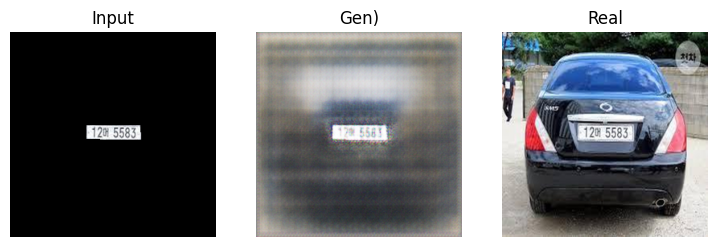

[Epoch 11/200] [G Loss: 34.5497] [Val L1: 0.4418] [LR: 0.000200]
EarlyStopping counter: 2/20
[Epoch 12/200] [G Loss: 34.3644] [Val L1: 0.4502] [LR: 0.000200]
EarlyStopping counter: 3/20
[Epoch 13/200] [G Loss: 33.9204] [Val L1: 0.4694] [LR: 0.000200]
EarlyStopping counter: 4/20
[Epoch 14/200] [G Loss: 33.6258] [Val L1: 0.4487] [LR: 0.000200]
EarlyStopping counter: 5/20
[Epoch 15/200] [G Loss: 33.0135] [Val L1: 0.4555] [LR: 0.000200]
EarlyStopping counter: 6/20
[Epoch 16/200] [G Loss: 32.7830] [Val L1: 0.4681] [LR: 0.000200]
EarlyStopping counter: 7/20
[Epoch 17/200] [G Loss: 32.2795] [Val L1: 0.4714] [LR: 0.000200]
EarlyStopping counter: 8/20
[Epoch 18/200] [G Loss: 31.8261] [Val L1: 0.4741] [LR: 0.000200]
EarlyStopping counter: 9/20
[Epoch 19/200] [G Loss: 31.5357] [Val L1: 0.4533] [LR: 0.000200]
EarlyStopping counter: 10/20
[Epoch 20/200] [G Loss: 30.9545] [Val L1: 0.4619] [LR: 0.000200]
EarlyStopping counter: 11/20


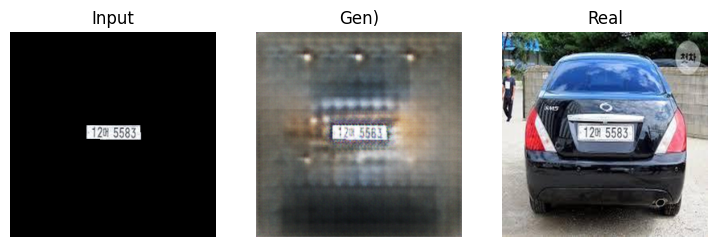

[Epoch 21/200] [G Loss: 30.4865] [Val L1: 0.4694] [LR: 0.000200]
EarlyStopping counter: 12/20
[Epoch 22/200] [G Loss: 30.1217] [Val L1: 0.4661] [LR: 0.000200]
EarlyStopping counter: 13/20
[Epoch 23/200] [G Loss: 29.7674] [Val L1: 0.4810] [LR: 0.000200]
EarlyStopping counter: 14/20
[Epoch 24/200] [G Loss: 29.3227] [Val L1: 0.4523] [LR: 0.000200]
EarlyStopping counter: 15/20
[Epoch 25/200] [G Loss: 28.7241] [Val L1: 0.5047] [LR: 0.000200]
EarlyStopping counter: 16/20
[Epoch 26/200] [G Loss: 28.5827] [Val L1: 0.4770] [LR: 0.000200]
EarlyStopping counter: 17/20
[Epoch 27/200] [G Loss: 28.2332] [Val L1: 0.4826] [LR: 0.000200]
EarlyStopping counter: 18/20
[Epoch 28/200] [G Loss: 27.6792] [Val L1: 0.4869] [LR: 0.000200]
EarlyStopping counter: 19/20
[Epoch 29/200] [G Loss: 27.4545] [Val L1: 0.4978] [LR: 0.000200]
EarlyStopping counter: 20/20
Early Stopping.
Done
Best model: best_generator.pth


In [ ]:
if __name__ == "__main__":
    # LOAD DATA
    try:
        full_dataset = CarPlateDataset(ROOT_DATA_DIR, transform=transform)
        val_size = int(len(full_dataset) * VAL_PERCENT)
        train_size = len(full_dataset) - val_size
        train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        print(f"Data Loaded: {len(full_dataset)} total. Train: {len(train_loader)*BATCH_SIZE}, Val: {len(val_loader)*BATCH_SIZE}")
    except Exception as e:
        print(f"Cannot load data: {e}")
        exit()

    # INIT MODELS
    generator = GeneratorUNet().to(DEVICE)
    discriminator = Discriminator().to(DEVICE)
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

    criterion_GAN = nn.MSELoss()
    criterion_pixelwise = nn.L1Loss()

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

    scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
    scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_rule)

    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path='best_generator.pth')

    # TRAINING LOOP
    start_time = time.time()

    for epoch in range(EPOCHS):
        # Train Phase
        generator.train(); discriminator.train()
        train_loss_G_total = 0.0

        for i, (imgs_input, imgs_real) in enumerate(train_loader):
            real_A = imgs_input.to(DEVICE)
            real_B = imgs_real.to(DEVICE)

            # Label
            valid = torch.ones((real_A.size(0), 1, 16, 16), requires_grad=False).to(DEVICE)
            fake = torch.zeros((real_A.size(0), 1, 16, 16), requires_grad=False).to(DEVICE)

            # Train G
            optimizer_G.zero_grad()
            fake_B = generator(real_A)
            loss_pixel = criterion_pixelwise(fake_B, real_B)
            pred_fake = discriminator(fake_B, real_A)
            valid_G = torch.ones_like(pred_fake, requires_grad=False).to(DEVICE)

            loss_GAN = criterion_GAN(pred_fake, valid_G)
            loss_G = loss_GAN + (LAMBDA_L1 * loss_pixel)

            loss_G.backward()
            optimizer_G.step()
            train_loss_G_total += loss_G.item()

            # Train D
            optimizer_D.zero_grad()
            pred_real = discriminator(real_B, real_A)
            valid_D = torch.ones_like(pred_real, requires_grad=False).to(DEVICE)
            loss_real = criterion_GAN(pred_real, valid_D)

            pred_fake_D = discriminator(fake_B.detach(), real_A)
            fake_D = torch.zeros_like(pred_fake_D, requires_grad=False).to(DEVICE)
            loss_fake = criterion_GAN(pred_fake_D, fake_D)

            loss_D = 0.5 * (loss_real + loss_fake)
            loss_D.backward()
            optimizer_D.step()

        # Validation Phase
        generator.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs_input, imgs_real in val_loader:
                real_A = imgs_input.to(DEVICE)
                real_B = imgs_real.to(DEVICE)
                fake_B = generator(real_A)
                loss = criterion_pixelwise(fake_B, real_B)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Update Scheduler & Logging
        scheduler_G.step()
        scheduler_D.step()

        print(f"[Epoch {epoch}/{EPOCHS}] "
              f"[G Loss: {train_loss_G_total/len(train_loader):.4f}] "
              f"[Val L1: {val_loss:.4f}] "
              f"[LR: {optimizer_G.param_groups[0]['lr']:.6f}]")

        # Check Early Stopping
        early_stopping(val_loss, generator)

        if epoch % 10 == 0:
            with torch.no_grad():
                sample_in = real_A[0].unsqueeze(0)
                sample_gen = generator(sample_in)
                sample_real = real_B[0].unsqueeze(0)

                fig, ax = plt.subplots(1, 3, figsize=(9, 3))
                ax[0].imshow(sample_in[0].permute(1, 2, 0).cpu() * 0.5 + 0.5)
                ax[0].set_title("Input")
                ax[0].axis('off')
                ax[1].imshow(sample_gen[0].permute(1, 2, 0).cpu() * 0.5 + 0.5)
                ax[1].set_title("Gen)")
                ax[1].axis('off')
                ax[2].imshow(sample_real[0].permute(1, 2, 0).cpu() * 0.5 + 0.5)
                ax[2].set_title("Real")
                ax[2].axis('off')
                plt.show()

        if early_stopping.early_stop:
            print("Early Stopping.")
            break

    print("Done")
    print(f"Best model: {early_stopping.path}")

In [ ]:
!cp generator_final.pth /content/drive/MyDrive/ImageOutpainting/Models

cp: cannot stat 'generator_final.pth': No such file or directory


# Inference

In [ ]:
model_path = "/content/drive/MyDrive/ImageOutpainting/Models/generator_final.pth"

In [ ]:
def inference_test(crop_img_path, model_path='best_generator.pth'):
    if not os.path.exists(model_path):
        print("Not found model!")
        return

    gen = GeneratorUNet().to(DEVICE)
    gen.load_state_dict(torch.load(model_path, map_location=DEVICE))
    gen.eval()

    img = Image.open(crop_img_path).convert("RGB")
    w, h = img.size

    canvas = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0, 0, 0))

    target_w = int(IMG_SIZE * 0.35)
    scale = target_w / w
    new_w, new_h = int(w * scale), int(h * scale)
    img_resized = img.resize((new_w, new_h), Image.BICUBIC)

    x = (IMG_SIZE - new_w) // 2
    y = int(IMG_SIZE * 0.65)

    canvas.paste(img_resized, (x, y))

    # Run
    t = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,)*3, (0.5,)*3)])
    inp_tensor = t(canvas).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out_tensor = gen(inp_tensor)

    # Show
    out_img = out_tensor[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
    plt.imshow(out_img)
    plt.title("Kết quả Inference")
    plt.axis('off')
    plt.show()

In [ ]:
test_image_path = "/content/drive/MyDrive/ImageOutpainting/datasets/inference/test.jpg"

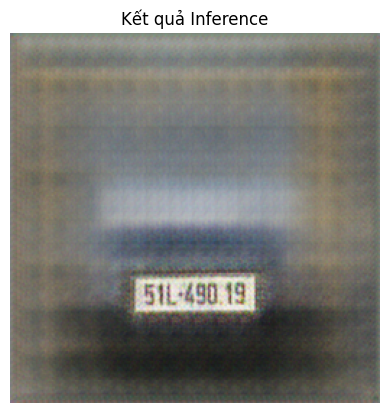

In [ ]:
inference_test(test_image_path)

In [ ]:
run_inference(test_image_path)